In [1]:
from typing import Dict, Any, IO,Optional,Tuple, Union,List
import os
import gc
import sys
import copy
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader
sys.path.append('/workspace/causal-retified-flow/src')
sys.path.append('/workspace/causal-retified-flow/src/pgm')
import multiprocessing
import numpy as np
from tqdm import tqdm

from pgm.train_pgm import setup_dataloaders,preprocess
from pgm.flow_pgm import MorphoMNISTPGM

class Hparams:
    def update(self, dict):
        for k, v in dict.items():
            setattr(self, k, v)

/venv/causal-gen/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/venv/causal-gen/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
predictor_path = '/workspace/checkpoints/t_i_d/aux_60k/checkpoint.pt'
print(f'\nLoading predictor checkpoint: {predictor_path}')
predictor_checkpoint = torch.load(predictor_path)
predictor_args = Hparams()
predictor_args.update(predictor_checkpoint['hparams'])
assert predictor_args.dataset == 'morphomnist'
predictor = MorphoMNISTPGM(predictor_args).cuda()
predictor.load_state_dict(predictor_checkpoint['ema_model_state_dict'])


Loading predictor checkpoint: /workspace/checkpoints/t_i_d/aux_60k/checkpoint.pt


<All keys matched successfully>

In [3]:
pgm_path = '/workspace/checkpoints/t_i_d/pgm_60k/checkpoint.pt'
print(f'\nLoading PGM checkpoint: {pgm_path}')
pgm_checkpoint = torch.load(pgm_path)
pgm_args = Hparams()
pgm_args.update(pgm_checkpoint['hparams'])
assert pgm_args.dataset == 'morphomnist'
pgm = MorphoMNISTPGM(pgm_args).cuda()
pgm.load_state_dict(pgm_checkpoint['ema_model_state_dict'])


Loading PGM checkpoint: /workspace/checkpoints/t_i_d/pgm_60k/checkpoint.pt


<All keys matched successfully>

In [4]:
import os
model_name = 'flow_matching_exp'
fm_path = '/workspace/checkpoints/t_i_d/'+model_name+'/checkpoint.pt'
print(os.path.exists(fm_path), os.path.getsize(fm_path) if os.path.exists(fm_path) else 'File not found')

True 536408501


In [5]:
def load_fm(fm_path):
    print(f'\nLoading flow matching checkpoint: {fm_path}')
    fm_checkpoint = torch.load(fm_path)
    fm_args = Hparams()
    fm_args.update(fm_checkpoint['hparams'])
    fm_args.data_dir = '../datasets/'

    # init model
    assert fm_args.hps == 'morphomnist'
    from flow_model import FlowUnet
    fm=FlowUnet(fm_args).cuda()
    fm.load_state_dict(fm_checkpoint['ema_model_state_dict'])
    return fm, fm_args

model_name = 'flow_matching_exp'
fm_path = '/workspace/checkpoints/t_i_d/'+model_name+'/checkpoint.pt'
fm, fm_args = load_fm(fm_path)


Loading flow matching checkpoint: /workspace/checkpoints/t_i_d/flow_matching_exp/checkpoint.pt


In [8]:
from morphomnist.morpho import ImageMorphology
import pdb
# Refer to https://github.com/dccastro/Morpho-MNIST for details on Morpho-MNIST
from flow_model import RectifiedFlow
def get_intensity(x, threshold=0.5):
    x = x.detach().cpu().numpy()[:, 0]
    x_min, x_max = x.min(axis=(1, 2), keepdims=True), x.max(axis=(1, 2), keepdims=True)
    mask = (x >= x_min + (x_max - x_min) * threshold)
    return np.array([np.median(i[m]) for i, m in zip(x, mask)])

def img_thickness(img, threshold, scale):
    return ImageMorphology(np.asarray(img), threshold, scale).mean_thickness

def unpack(args):
    return img_thickness(*args)

def get_thickness(x, threshold=0.5, scale=4, pool=None, chunksize=100):
    imgs = x.detach().cpu().numpy()[:, 0]
    args = ((img, threshold, scale) for img in imgs)
    if pool is None:
        gen = map(unpack, args)
    else:
        gen = pool.imap(unpack, args, chunksize=chunksize)
    results = tqdm(gen, total=len(imgs), unit='img', ascii=True)
    return list(results)

def fm_preprocess(pa: Dict[str, Tensor], input_res: int = 28) -> Tensor:
    # concatenate parents and expand to input resolution for vae input
    for k,v in pa.items():
        pa[k]=pa[k].unsqueeze(-1)
    return pa

    
@torch.no_grad()
def cf_epoch(
    vae: nn.Module, 
    pgm: nn.Module, 
    predictor: nn.Module, 
    dataloaders: Dict[str, DataLoader],
    do_pa: Optional[str] = None, 
    te_cf: bool = False
) -> Tuple[Tensor, Tensor, Tensor]:
    vae.eval()
    pgm.eval()
    predictor.eval()
    dag_vars = list(pgm.variables.keys())
    preds = {k: [] for k in dag_vars}
    targets = {k: [] for k in dag_vars}
    x_counterfactuals = []
    train_set = copy.deepcopy(dataloaders['train'].dataset.samples)
    loader = tqdm(enumerate(dataloaders['test']), total=len(
        dataloaders['test']), mininterval=0.1)

    for _, batch in loader:
        bs = batch['x'].shape[0]
        batch = preprocess(batch)
        pa = {k: v for k, v in batch.items() if k != 'x'}
        # randomly intervene on a single parent do(pa_k), pa_k ~ p(pa_k)
        do = {}
        if do_pa is not None:
            idx = torch.randperm(train_set[do_pa].shape[0])
            do[do_pa] = train_set[do_pa].clone()[idx][:bs]
        else: # random interventions
            while not do:
                for k in dag_vars:
                    if torch.rand(1) > 0.5:  # coin flip to intervene on pa_k
                        idx = torch.randperm(train_set[k].shape[0])
                        do[k] = train_set[k].clone()[idx][:bs]
        do = preprocess(do)
        # infer counterfactual parents
        cf_pa = pgm.counterfactual(obs=pa, intervention=do, num_particles=1)
        # abduct exogenous noise u
        u = fm.abduct(batch['x'], parents=pa, args=fm_args)
        # prediction
        cf_x = fm.sample_with_cf(rf=RectifiedFlow(), x_0=u, args=fm_args, cf_parents=cf_pa)
        cfs = {'x': torch.clamp(cf_x, min=-1, max=1)}
        cfs.update(cf_pa)
        x_counterfactuals.extend(cfs['x'])
        # predict labels of inferred counterfactuals
        preds_cf = predictor.predict(**cfs)
        for k, v in preds_cf.items():
            preds[k].extend(v)
        # targets are the interventions and/or counterfactual parents
        for k in targets.keys():
            t_k = do[k].clone() if k in do.keys() else cfs[k].clone()
            targets[k].extend(t_k)
    for k, v in targets.items():
        targets[k] = torch.stack(v).squeeze().cpu()
        preds[k] = torch.stack(preds[k]).squeeze().cpu()
    x_counterfactuals = torch.stack(x_counterfactuals).cpu()
    return targets, preds, x_counterfactuals


def eval_cf_loop(
    vae: nn.Module,
    pgm: nn.Module,
    predictor: nn.Module,
    dataloaders: Dict[str, DataLoader],
    file: IO[str],
    total_effect: bool = False,
    seeds: List[int] = [0],
):
    for do_pa in ['thickness', 'intensity', 'digit', None]:  # "None" is for random interventions
        acc_runs = []
        mae_runs = {
            'thickness': {'predicted': [], 'measured': []},
            'intensity': {'predicted': [], 'measured': []}
        }

        for seed in seeds:
            print(f'do({(do_pa if do_pa is not None else "random")}), seed {seed}:')
            targets, preds, x_cfs = cf_epoch(vae, pgm, predictor, dataloaders, do_pa, total_effect)
            acc = (targets['digit'].argmax(-1).numpy() == preds['digit'].argmax(-1).numpy()).mean()
            print(f'predicted digit acc:', acc)
            # evaluate inferred cfs using true causal mechanisms
            measured = {}
            measured['intensity'] = torch.tensor(get_intensity((x_cfs + 1.0) * 127.5))
            with multiprocessing.Pool() as pool:
                measured['thickness'] = torch.tensor(get_thickness((x_cfs + 1.0) * 127.5, pool=pool, chunksize=250))

            mae = {'thickness': {}, 'intensity': {}}
            for k in ['thickness', 'intensity']:
                min_max = dataloaders['train'].dataset.min_max[k]
                _min, _max = min_max[0], min_max[1]
                preds_k = ((preds[k] + 1) / 2) * (_max - _min) + _min
                targets_k = ((targets[k] + 1) / 2) * (_max - _min) + _min
                mae[k]['predicted'] = (targets_k - preds_k).abs().mean().item()
                mae[k]['measured'] = (targets_k - measured[k]).abs().mean().item()
                print(f'predicted {k} mae:', mae[k]['predicted'])
                print(f'measured {k} mae:', mae[k]['measured'])

            acc_runs.append(acc)
            for k in ['thickness', 'intensity']:
                mae_runs[k]['predicted'].append(mae[k]['predicted'])
                mae_runs[k]['measured'].append(mae[k]['measured'])

            file.write(
                f'\ndo({(do_pa if do_pa is not None else "random")}) | digit acc: {acc}, ' +
                f'thickness mae (predicted): {mae["thickness"]["predicted"]}, ' +
                f'thickness mae (measured): {mae["thickness"]["measured"]}, ' +
                f'intensity mae (predicted): {mae["intensity"]["predicted"]}, ' +
                f'intensity mae (measured): {mae["intensity"]["measured"]} | seed {seed}'
            )
            file.flush()
            gc.collect()

        v = 'Total effect: '+ str(total_effect)
        file.write(
            f'\n{v}\n' +
            f'digit acc | mean: {np.array(acc_runs).mean()} - std: {np.array(acc_runs).std()}\n' +
            f'thickness mae (predicted) | mean: {np.array(mae_runs["thickness"]["predicted"]).mean()} - std: {np.array(mae_runs["thickness"]["predicted"]).std()}\n' +
            f'thickness mae (measured) | mean: {np.array(mae_runs["thickness"]["measured"]).mean()} - std: {np.array(mae_runs["thickness"]["measured"]).std()}\n' +
            f'intensity mae (predicted) | mean: {np.array(mae_runs["intensity"]["predicted"]).mean()} - std: {np.array(mae_runs["intensity"]["predicted"]).std()}\n' +
            f'intensity mae (measured) | mean: {np.array(mae_runs["intensity"]["measured"]).mean()} - std: {np.array(mae_runs["intensity"]["measured"]).std()}\n'
        )
        file.flush()
    return

for model_name in [
'flow_matching_exp'
]:
    file = open(f'./eval_{model_name}.txt', 'a')
    fm_path = '/workspace/checkpoints/t_i_d/'+model_name+'/checkpoint.pt'
    fm, fm_args = load_fm(fm_path)
    assert pgm_args.dataset == 'morphomnist'
    pgm_args.data_dir = '/workspace/causal-gen/datasets/morphomnist'
    pgm_args.bs = 32
    dataloaders = setup_dataloaders(pgm_args)
    eval_cf_loop(fm, pgm, predictor, dataloaders, file)
    file.close()


Loading flow matching checkpoint: /workspace/checkpoints/t_i_d/flow_matching_exp/checkpoint.pt
thickness normalization: [-1,1]
max: 6.255515, min: 0.87598526
intensity normalization: [-1,1]
max: 254.90317, min: 66.601204
#samples: 60000

thickness normalization: [-1,1]
max: 6.255515, min: 0.87598526
intensity normalization: [-1,1]
max: 254.90317, min: 66.601204
#samples: 10000

thickness normalization: [-1,1]
max: 6.255515, min: 0.87598526
intensity normalization: [-1,1]
max: 254.90317, min: 66.601204
#samples: 10000

do(thickness), seed 0:
thickness normalization: [-1,1]
max: 6.255515, min: 0.87598526
intensity normalization: [-1,1]
max: 254.90317, min: 66.601204
#samples: 60000

thickness normalization: [-1,1]
max: 6.255515, min: 0.87598526
intensity normalization: [-1,1]
max: 254.90317, min: 66.601204
#samples: 10000

thickness normalization: [-1,1]
max: 6.255515, min: 0.87598526
intensity normalization: [-1,1]
max: 254.90317, min: 66.601204
#samples: 10000

do(thickness), seed 0:


100%|██████████| 313/313 [04:31<00:00,  1.15it/s]



predicted digit acc: 0.9952


100%|##########| 10000/10000 [01:59<00:00, 83.99img/s]



predicted thickness mae: 0.5486329793930054
measured thickness mae: 0.6961509858999434
predicted intensity mae: 48.66401290893555
measured intensity mae: 49.01017761230469
do(intensity), seed 0:


100%|██████████| 313/313 [04:31<00:00,  1.15it/s]



predicted digit acc: 0.9956


100%|##########| 10000/10000 [01:59<00:00, 83.45img/s]



predicted thickness mae: 0.16441011428833008
measured thickness mae: 0.13351028761266215
predicted intensity mae: 54.53118133544922
measured intensity mae: 54.982948303222656
do(digit), seed 0:


100%|██████████| 313/313 [04:32<00:00,  1.15it/s]



predicted digit acc: 0.7922


100%|##########| 10000/10000 [01:59<00:00, 83.87img/s]



predicted thickness mae: 0.22352023422718048
measured thickness mae: 0.3193408750182205
predicted intensity mae: 33.7902717590332
measured intensity mae: 35.34321975708008
do(random), seed 0:


100%|██████████| 313/313 [04:32<00:00,  1.15it/s]



predicted digit acc: 0.8825


100%|##########| 10000/10000 [01:59<00:00, 83.78img/s]



predicted thickness mae: 0.4435769021511078
measured thickness mae: 0.535134611286748
predicted intensity mae: 53.72004318237305
measured intensity mae: 54.78707504272461


In [39]:
import matplotlib.pyplot as plt

def visualize_counterfactuals(original_images, cf_images, original_labels, cf_labels, num_samples=8):
    """
    Visualize original images vs their counterfactuals
    """
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 4))
    
    for i in range(min(num_samples, len(original_images))):
        # Original image
        orig_img = original_images[i].squeeze().numpy()
        axes[0, i].imshow(orig_img, cmap='gray',vmin=0, vmax=255)
        
        # Convert tensors to scalars for formatting
        orig_digit = original_labels["digit"][i].argmax().item()
        orig_thick = original_labels["thickness"][i].item()
        orig_int = original_labels["intensity"][i].item()
        
        axes[0, i].set_title(f'Original\nDigit: {orig_digit:.0f}\nThick: {orig_thick:.2f}\nInt: {orig_int:.2f}')
        axes[0, i].axis('off')
        
        # Counterfactual image
        cf_img = cf_images[i].squeeze().numpy()
        axes[1, i].imshow(cf_img, cmap='gray',vmin=0, vmax=255)
        
        # Convert tensors to scalars for formatting
        cf_digit = cf_labels["digit"][i].argmax().item()
        cf_thick = cf_labels["thickness"][i].item()
        cf_int = cf_labels["intensity"][i].item()
        
        axes[1, i].set_title(f'Counterfactual\nDigit: {cf_digit:.0f}\nThick: {cf_thick:.2f}\nInt: {cf_int:.2f}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Test visualization with a small batch
def test_cf_visualization(fm, pgm, predictor, dataloaders, num_samples=8):
    """
    Generate and visualize counterfactuals for a small test batch
    """
    fm.eval()
    pgm.eval()
    predictor.eval()
    
    # Get a small batch from test set
    test_batch = next(iter(dataloaders['test']))
    test_batch = {k: v[:num_samples] for k, v in test_batch.items()}  # Take only num_samples
    batch = preprocess(test_batch)
    
    # Original data
    original_x = batch['x']
    original_pa = {k: v for k, v in batch.items() if k != 'x'}
    original_preds = predictor.predict(x=original_x, **original_pa)
    
    # Create intervention (let's try increasing thickness)
    train_set = dataloaders['train'].dataset.samples
    do = {}
    # Intervene on thickness - set to high values
    high_thickness_indices = torch.argsort(train_set['thickness'], descending=True)[:num_samples]
    do['thickness'] = train_set['thickness'][high_thickness_indices]
    do = preprocess(do)

    
    # Generate counterfactuals
    cf_pa = pgm.counterfactual(obs=original_pa, intervention=do, num_particles=1)
    u = fm.abduct(original_x, parents=original_pa, args=fm_args)
    cf_x = fm.sample_with_cf(rf=RectifiedFlow(), x_0=u, args=fm_args, cf_parents=cf_pa)
    cf_x = torch.clamp(cf_x, min=-1, max=1)
    
    # Predict counterfactual labels
    cf_preds = predictor.predict(x=cf_x, **cf_pa)
    
    # Convert to display format (0-255)
    orig_display = ((original_x + 1) * 127.5).cpu()
    cf_display = ((cf_x + 1) * 127.5).cpu()
    
    # Denormalize labels for display
    def denormalize_labels(labels, dataloaders):
        denorm = {}
        for k, v in labels.items():
            if k in ['thickness', 'intensity']:
                min_max = dataloaders['train'].dataset.min_max[k]
                _min, _max = min_max[0], min_max[1]
                denorm[k] = ((v + 1) / 2) * (_max - _min) + _min
            else:
                denorm[k] = v
        return denorm
    
    orig_labels_denorm = denormalize_labels(original_preds, dataloaders)
    cf_labels_denorm = denormalize_labels(cf_preds, dataloaders)
    
    # Visualize
    visualize_counterfactuals(orig_display, cf_display, orig_labels_denorm, cf_labels_denorm, num_samples)
    
    return orig_display, cf_display, orig_labels_denorm, cf_labels_denorm

In [43]:
def test_cf_visualization_intensity(fm, pgm, predictor, dataloaders, intensity_targets=[70, 80, 90]):
    """
    Generate and visualize counterfactuals for a small test batch with specific intensity interventions.
    """
    fm.eval()
    pgm.eval()
    predictor.eval()
    num_samples = len(intensity_targets)
    
    # Get a small batch from test set
    test_batch = next(iter(dataloaders['test']))
    test_batch = {k: v[:num_samples] for k, v in test_batch.items()}  # Take only num_samples
    batch = preprocess(test_batch)
    
    # Original data
    original_x = batch['x']
    original_pa = {k: v for k, v in batch.items() if k != 'x'}
    original_preds = predictor.predict(x=original_x, **original_pa)
    
    # Prepare intensity intervention (normalize to [-1, 1])
    intensity_min, intensity_max = dataloaders['train'].dataset.min_max['intensity']
    intensity_norm = [2 * (t - intensity_min) / (intensity_max - intensity_min) - 1 for t in intensity_targets]
    print(intensity_norm)
    do = {'intensity': torch.tensor(intensity_norm, dtype=original_x.dtype, device=original_x.device)}
    do = preprocess(do)
    
    # Generate counterfactuals
    cf_pa = pgm.counterfactual(obs=original_pa, intervention=do, num_particles=1)
    u = fm.abduct(original_x, parents=original_pa, args=fm_args)
    cf_x = fm.sample_with_cf(rf=RectifiedFlow(), x_0=u, args=fm_args, cf_parents=cf_pa)
    cf_x = torch.clamp(cf_x, min=-1, max=1)
    
    # Predict counterfactual labels
    cf_preds = predictor.predict(x=cf_x, **cf_pa)
    
    # Convert to display format (0-255)
    orig_display = ((original_x + 1) * 127.5).cpu()
    cf_display = ((cf_x + 1) * 127.5).cpu()
    
    # Denormalize labels for display
    def denormalize_labels(labels, dataloaders):
        denorm = {}
        for k, v in labels.items():
            if k in ['thickness', 'intensity']:
                min_max = dataloaders['train'].dataset.min_max[k]
                _min, _max = min_max[0], min_max[1]
                denorm[k] = ((v + 1) / 2) * (_max - _min) + _min
            else:
                denorm[k] = v
        return denorm
    
    orig_labels_denorm = denormalize_labels(original_preds, dataloaders)
    cf_labels_denorm = denormalize_labels(cf_preds, dataloaders)
    
    # Visualize
    visualize_counterfactuals(orig_display, cf_display, orig_labels_denorm, cf_labels_denorm, num_samples)
    
    return orig_display, cf_display, orig_labels_denorm, cf_labels_denorm


Generating counterfactual visualizations...


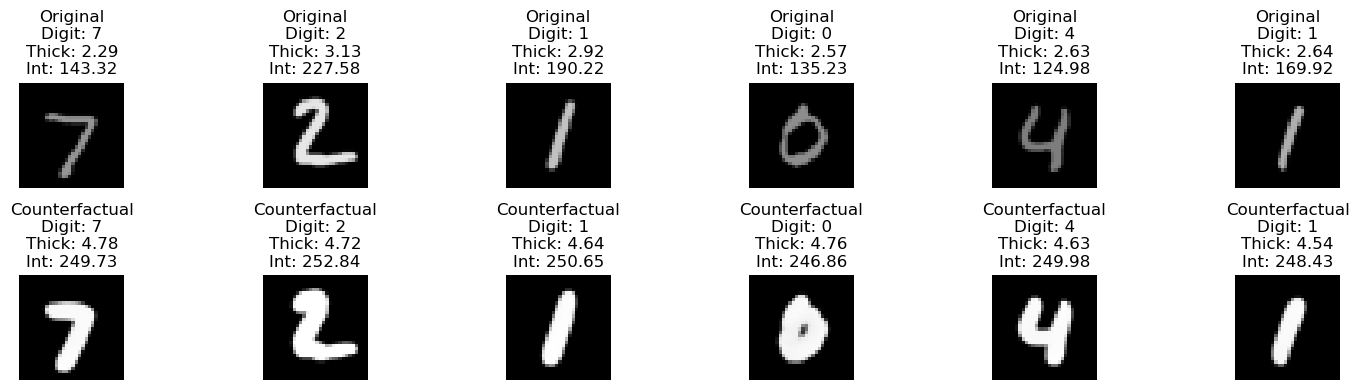


Original vs Counterfactual comparison:
Top row: Original images
Bottom row: Counterfactuals (with increased thickness intervention)
Each image shows: Digit class, Thickness value, Intensity value


In [42]:
# Generate and visualize counterfactual examples
print("Generating counterfactual visualizations...")
orig_imgs, cf_imgs, orig_labels, cf_labels = test_cf_visualization(fm, pgm, predictor, dataloaders, num_samples=6)

print("\nOriginal vs Counterfactual comparison:")
print("Top row: Original images")
print("Bottom row: Counterfactuals (with increased thickness intervention)")
print("Each image shows: Digit class, Thickness value, Intensity value")

Generating counterfactuals with intensity interventions (brightness 70, 80, 90)...
[-0.9639005787119609, -0.8576881985395733, -0.7514758183671858]


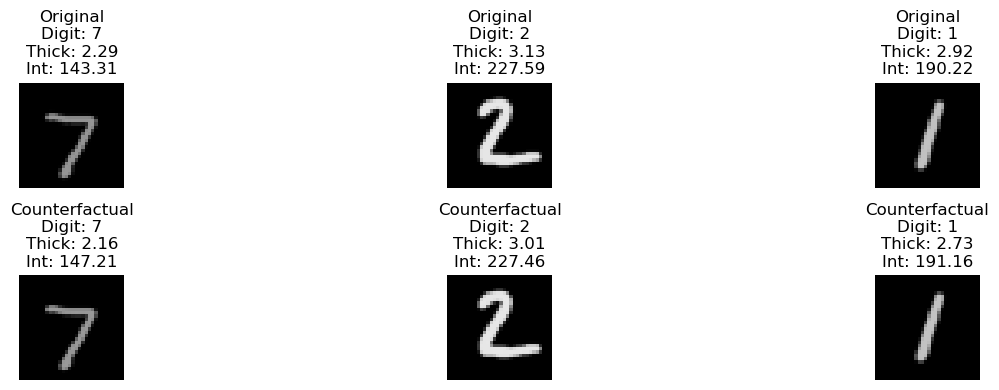


Original vs Counterfactual comparison:
Top row: Original images
Bottom row: Counterfactuals (with intensity set to 70, 80, 90)
Each image shows: Digit class, Thickness value, Intensity value

Measured mean pixel intensity (0-255 scale):
Sample 1: Original=11.22, Counterfactual=11.61, Target=70
Sample 2: Original=31.64, Counterfactual=31.59, Target=80
Sample 3: Original=12.28, Counterfactual=12.40, Target=90


In [44]:
# Visualize counterfactuals with specific intensity interventions
import numpy as np
import matplotlib.pyplot as plt

print("Generating counterfactuals with intensity interventions (brightness 70, 80, 90)...")
orig_imgs, cf_imgs, orig_labels, cf_labels = test_cf_visualization_intensity(fm, pgm, predictor, dataloaders, intensity_targets=[70, 80, 90])

# Compute measured mean intensity (mean pixel value) for each image
def measured_intensity(imgs):
    # imgs: torch.Tensor, shape (N, 1, H, W) or (N, H, W)
    arr = imgs.numpy() if hasattr(imgs, 'numpy') else np.array(imgs)
    if arr.ndim == 4:
        arr = arr[:, 0]
    return arr.mean(axis=(1,2))

orig_measured_int = measured_intensity(orig_imgs)
cf_measured_int = measured_intensity(cf_imgs)

print("\nOriginal vs Counterfactual comparison:")
print("Top row: Original images")
print("Bottom row: Counterfactuals (with intensity set to 70, 80, 90)")
print("Each image shows: Digit class, Thickness value, Intensity value")

print("\nMeasured mean pixel intensity (0-255 scale):")
for i in range(len(orig_imgs)):
    print(f"Sample {i+1}: Original={orig_measured_int[i]:.2f}, Counterfactual={cf_measured_int[i]:.2f}, Target={ [70,80,90][i] }")

